# **The AR model**

## **1. Describing a dataframe**

In [1]:
import pandas as pd

# Import the dataframe
eq = pd.read_csv('Earthquake_database.csv')

# Describe the dataframe
eq.describe()

,Latitude,Longitude,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square
count,23412.000000,23412.000000,23412.000000,4461.000000,7097.000000,23412.000000,327.000000,2564.000000,7299.000000,1604.000000,1156.000000,17352.000000
mean,1.679033,39.639961,70.767911,4.993115,275.364098,5.882531,0.071820,48.944618,44.163532,3.992660,7.662759,1.022784
std,30.113183,125.511959,122.651898,4.875184,162.141631,0.423066,0.051466,62.943106,32.141486,5.377262,10.430396,0.188545
min,-77.080000,-179.997000,-1.100000,0.000000,0.000000,5.500000,0.000000,0.000000,0.000000,0.004505,0.085000,0.000000
25%,-18.653000,-76.349750,14.522500,1.800000,146.000000,5.600000,0.046000,10.000000,24.100000,0.968750,5.300000,0.900000
50%,-3.568500,103.982000,33.000000,3.500000,255.000000,5.700000,0.059000,28.000000,36.000000,2.319500,6.700000,1.000000
75%,26.190750,145.026250,54.000000,6.300000,384.000000,6.000000,0.075500,66.000000,54.000000,4.724500,8.100000,1.130000
max,86.005000,179.998000,700.000000,91.295000,934.000000,9.100000,0.410000,821.000000,360.000000,37.874000,99.000000,3.440000


## **2. Convert the earthquake data to the yearly number of earthquake**

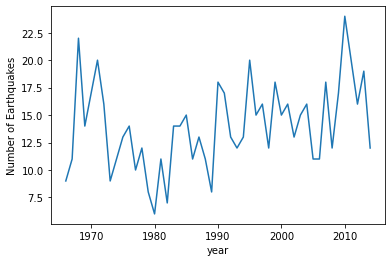

In [2]:
import matplotlib.pyplot as plt

# Convert years to dates
eq['year'] = pd.to_datetime(eq['Date'], utc=True).dt.year

# Filter on earthquakes with magnitude of 7 or higher
eq = eq[eq['Magnitude'] >= 7]

# Compute a count of earthquakes per year
earthquakes_per_year = eq.groupby('year').count()

# Remove erroneous values for year
earthquakes_per_year = earthquakes_per_year.iloc[1:-2, 0]

# Make a plot of earthquakes per year
ax = earthquakes_per_year.plot()
ax.set_ylabel("Number of Earthquakes")
plt.show()

## **3. Convert the earthquake data to the yearly number of earthquake**

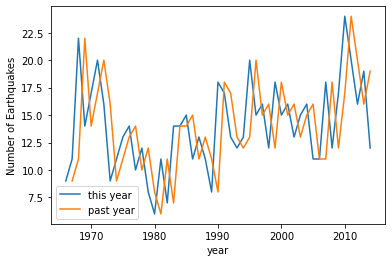

In [3]:
shifts = pd.DataFrame(
    {
        'this year': earthquakes_per_year,
        'past year': earthquakes_per_year.shift(1)
    }
)

ax = shifts.plot()
ax.set_ylabel('Number of Earthquakes')
plt.show()

## **4. Drop missing data**

In [4]:
shifts = shifts.dropna()

## **5. Compute a correlation matrix for the shifts dataframe**

In [5]:
shifts.corr()

,this year,past year
this year,1.000000,0.313667
past year,0.313667,1.000000


## **6. Augmented Dicky Fuller test**

In [6]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(earthquakes_per_year.dropna())
print(result)

pvalue = result[1]
if pvalue < 0.05:
    print('stationary')
else:
    print('not stationary')

(-5.008806133844327, 2.1319566272140453e-05, 0, 48, {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}, 202.7529751691226)
stationary


## **7. Differencing in pandas**

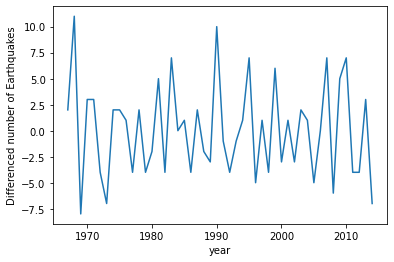

In [7]:
# Difference the data
differenced_data = earthquakes_per_year.diff().dropna()

# Plot the differenced data
ax = differenced_data.plot()
ax.set_ylabel('Differenced number of Earthquakes')
plt.show()

## **8. Autocorrelation of the differenced data**

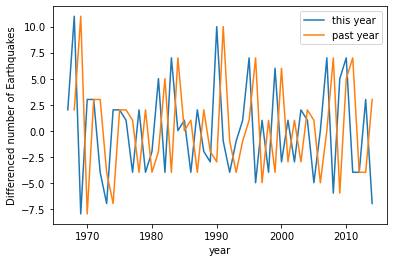

,this year,past year
this year,1.000000,-0.376859
past year,-0.376859,1.000000


In [8]:
shifts_diff = pd.DataFrame(
    {
        'this year': differenced_data,
        'past year': differenced_data.shift(1)
    }
)

ax = shifts_diff.plot()
ax.set_ylabel('Differenced number of Earthquakes')
plt.show()

shifts_diff.corr()

## **9. Autocorrelation of the differenced data**

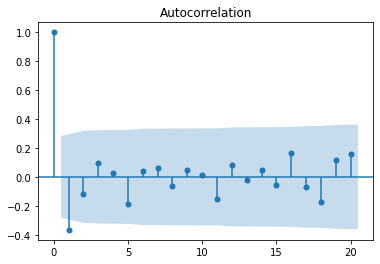

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(differenced_data, lags=20)
plt.show()

## **10. Autocorrelation of the differenced data**

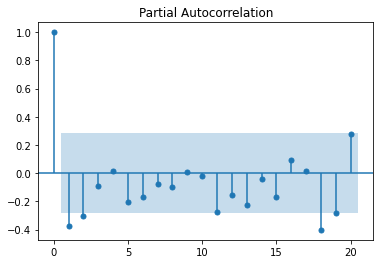

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(differenced_data, lags = 20)
plt.show()

## **11. Estimate Yule Walker AR coefficients with order 3**

In [11]:
from statsmodels.regression.linear_model import yule_walker
coefficients, sigma = yule_walker(differenced_data, order = 3)
print('coefficients: ', -coefficients)
print('sigma: ', sigma)

coefficients:  [0.51636104 0.34981679 0.08922855]
sigma:  3.99051873543974


## **12. Make a Forecast with the AR coefficients**

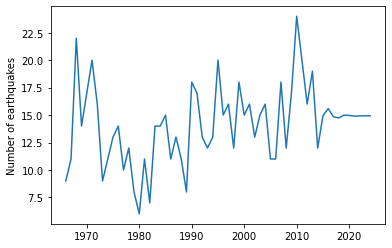

In [12]:
coefficients, sigma = yule_walker(differenced_data, order = 3)

# Make a list of differenced values
val_list = list(differenced_data)
# Reverse the list so that the order corresponds with the order of the coefficients
val_list.reverse()
# Define the number of years to predict
n_steps = 10

# For each year to predict
for i in range(n_steps):
    
    # Compute the new value as the sum of lagged values multiplied by their corresponding coefficient
    new_val = 0
    for j in range(len(coefficients)):
        
        new_val += coefficients[j] * val_list[j]
    
    # Insert the new value at the beginning of the list
    val_list.insert(0, new_val)

# Redo the reverse to have the order of time
val_list.reverse()

# Add the original first value back into the list and do a cumulative sum to undo the differencing 
val_list = [earthquakes_per_year.values[0]] + val_list
new_val_list = pd.Series(val_list).cumsum()

# Plot the newly obtained list
plt.plot(range(1966, 2025), new_val_list)
plt.ylabel('Number of earthquakes')
plt.show()


## **13. Fit the model on a train set and evaluate it on a test set**

Test R2: -0.040346700807336155


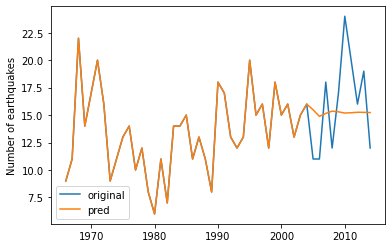

In [14]:
from sklearn.metrics import r2_score

train = list(differenced_data)[:-10]
test = list(earthquakes_per_year)[-10:]

coefficients, sigma = yule_walker(train, order = 3)

# Make a list of differenced values
val_list = list(train)
# Reverse the list so that the order corresponds with the order of the coefficients
val_list.reverse()
# Define the number of years to predict
n_steps = 10

# For each year to predict
for i in range(n_steps):
    
    # Compute the new value as the sum of lagged values multiplied by their corresponding coefficient
    new_val = 0
    for j in range(len(coefficients)):
        
        new_val += coefficients[j] * val_list[j]
    
    # Insert the new value at the beginning of the list
    val_list.insert(0, new_val)

# Redo the reverso to have the order of time
val_list.reverse()

# Add the original first value back into the list and do a cumulative sum to undo the differencing 
val_list = [earthquakes_per_year.values[0]] + val_list
new_val_list = pd.Series(val_list).cumsum()

# Plot the newly obtained list
validation = pd.DataFrame({
    'original': earthquakes_per_year.reset_index(drop=True),
    'pred': new_val_list })

print('Test R2:', r2_score(validation.iloc[-10:, 0], validation.iloc[-10:, 1]))

# Plot the newly obtained list
plt.plot(range(1966, 2015), validation)
plt.legend(validation.columns)
plt.ylabel('Number of earthquakes')
plt.show()

## **14. Apply a grid search to find the order that gives the best R2 score on the test data**

In [16]:
def evaluate(order):
    train = list(differenced_data)[:-10]
    test = list(earthquakes_per_year)[-10:]

    coefficients, sigma = yule_walker(train, order = order)

    # Make a list of differenced values
    val_list = list(train)
    # Reverse the list to corresponds with the order of coefs
    val_list.reverse()
    # Define the number of years to predict
    n_steps = 10

    # For each year to predict
    for i in range(n_steps):

        # Compute the new value 
        new_val = 0
        for j in range(len(coefficients)):
            new_val += coefficients[j] * val_list[j]

        # Insert the new value at the beginning of the list
        val_list.insert(0, new_val)

    # Redo the reverse to have the order of time
    val_list.reverse()

    # Undo the differencing with a cumsum
    val_list = [earthquakes_per_year.values[0]] + val_list
    new_val_list = pd.Series(val_list).cumsum()

    # Plot the newly obtained list
    validation = pd.DataFrame({
        'original': earthquakes_per_year.reset_index(drop=True),
        'pred': new_val_list })

    return r2_score(validation.iloc[-10:, 0], validation.iloc[-10:, 1])

# For each order between 1 and 30, fit and evaluate the model
orders = []
r2scores = []
for order in range(1, 31):
    orders.append(order)
    r2scores.append(evaluate(order))
    
# Create a results data frame
results =pd.DataFrame({'orders': orders,
                      'scores': r2scores})

# Show the order with best R2 score
results[results['scores'] == results.max()['scores']]

/opt/conda/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/opt/conda/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/opt/conda/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


,orders,scores
18,19,0.133872
